# Séries temporais

In [1]:
!pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft
from scipy.fftpack import fftfreq
from scipy.signal import stft
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

## Carregar um exemplo de série temporal

Fonte da série: https://www.kaggle.com/shenba/time-series-datasets?select=monthly-beer-production-in-austr.csv


Caso o dataset estiver na mesma localização deste arquivo no seu computador, opcionalmente você pode utilizar o seguinte comando para carregar os dados:

st = pd.read_csv("monthly-beer-production-in-austr.csv")

In [3]:
st = pd.read_csv("https://raw.githubusercontent.com/jefferson-oliva/databases/master/monthly-beer-production-in-austr.csv")

In [4]:
st

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9
...,...,...
471,1995-04,127.0
472,1995-05,151.0
473,1995-06,130.0
474,1995-07,119.0


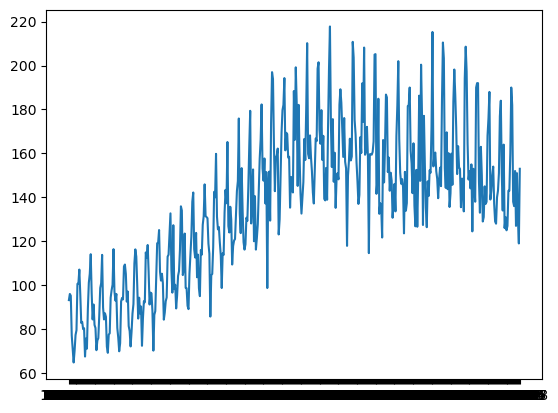

In [5]:
plt.plot(st['Month'], st['Monthly beer production'])
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

### Obtenção de dois segmentos de séries temporais referentes a uma década

In [6]:
s1 = np.asarray(st['Monthly beer production'][0:120])
s2 = np.asarray(st['Monthly beer production'][120:240])

### Obter os valores mínimo e máximo entre as duas séries temporais

In [7]:
y_min = min([min(s1), min(s2)])
y_max = max([max(s1), max(s2)])

### Plotagem das suas séries temporais

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


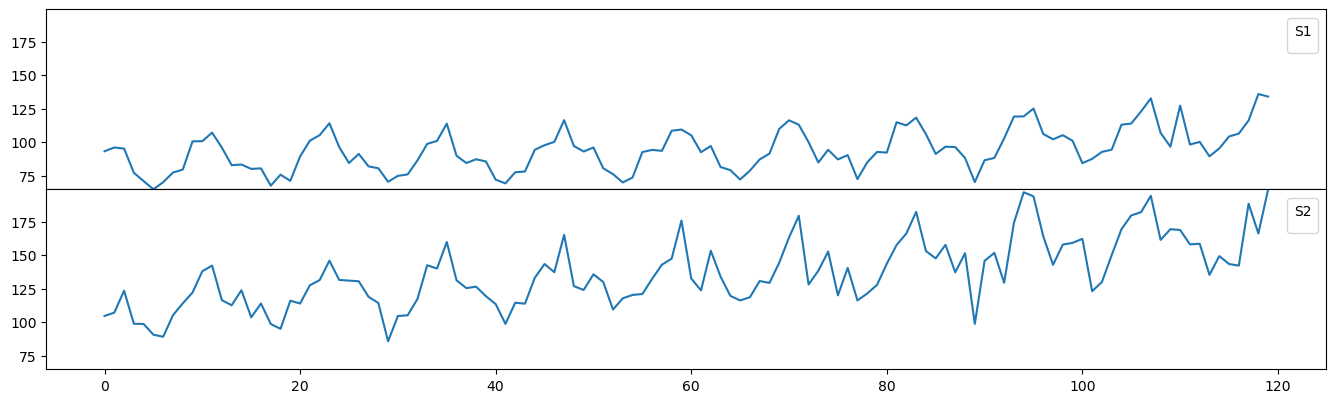

In [8]:
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.7, 0.8, 0.2], ylim=(y_min, y_max))
ax2 = fig.add_axes([0.1, 0.5, 0.8, 0.2], ylim=(y_min, y_max))
ax1.plot(s1)
ax2.plot(s2)
ax1.legend(title = "S1", loc = 1, fontsize=12)
ax2.legend(title = "S2", loc = 1, fontsize=12)

## Medidas de distância

### Distância euclidiana

$D_e(S1, S2) = \sum\limits_{t = 0}^{n - 1}\sqrt((S1[t] - S2[t])^{2})$

In [9]:
euclidean_distance = lambda s1, s2: np.sqrt(np.sum([(s1[i] - s2[i])**2 for i in range(len(s1))]))

In [10]:
euclidean_distance(s1, s2)

487.211730154355

### Distância de Manhattan

$D_m(S1, S2) = \sum\limits_{t = 0}^{n - 1}|S1_t - S2_t|$

In [11]:
manhattan_distance = lambda s1, s2: np.sum([np.abs(s1[i] - s2[i]) for i in range(len(s1))])

In [12]:
manhattan_distance(s1, s2)

5057.1

### Distância da norma $L_p$

$D_L(S1, S2) = \sum\limits_{t = 0}^{n - 1}(|S1_t - S2_t|^p){\frac{1}{p}}$

In [13]:
lp_distance = lambda s1, s2, p: (np.sum([np.abs(s1[i] - s2[i])**p for i in range(len(s1))]))**(1/p)

In [14]:
lp_distance(s1, s2, 1) # distância de Manhattan

5057.1

In [15]:
lp_distance(s1, s2, 2) # distância euclidiana

487.211730154355

### Para o cálculo das medidas de distância apresentadas até o momento, o pacote numpy tem a função norm

In [16]:
from numpy.linalg import norm

In [17]:
norm(s1 - s2, 1) # distância de Manhattan

5057.1

In [18]:
norm(s1 - s2, 2) # distância de euclidiana

487.21173015435494

In [19]:
norm(s1 - s2) # a função norm aplica a distância euclidiana por default

487.21173015435494

### Correlação-cruzada

$CC(S1,S2,\Phi)=\left\{\begin{array}{lccr}
			\sum\limits_{t=0}^{n-\Phi-1}S1_{i+\Phi} * S2_{i} & & & \Phi \geq 0 \\
			\\
			CC(S1,S2,-\Phi) & & & \Phi < 0 \\
			\end{array} \right.$
            
$\Phi$: parâmetro de deslocamento

In [20]:
def cross_correlation(s1, s2, m):
    if m < 0:
        return cross_correlation(s1, s2, -m)
    else:
        return np.sum([s1[i + m] * s2[i] for i in range(len(s1) - m)])

In [21]:
cross_correlation(s1, s2, 60)

750043.3

### Com a operação de correção-cruzada em todas as possibilidades de parâmetros de deslocamento, podemos gerar um correlograma

In [22]:
cc = np.asarray([cross_correlation(s1, s2, i) for i in range(-(len(s1) - 1), len(s1))])
x = [(i) for i in range((-len(s1)) + 1, len(s2))] # todos parâmetros de deslocamento utilizados

Text(0.5, 0, 'Deslocamento')

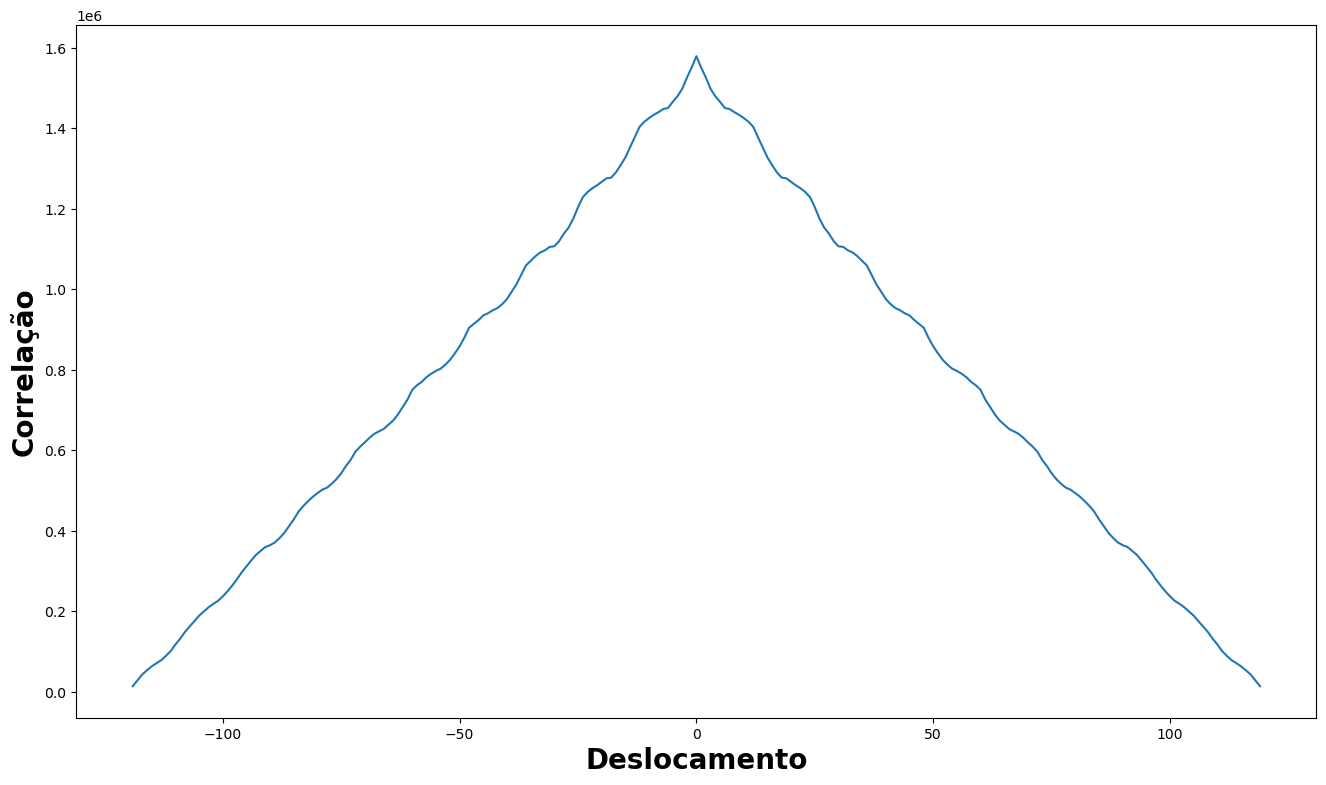

In [23]:
plt.plot(x, cc)
plt.ylabel('Correlação', fontsize = 20, fontweight = 'bold')
plt.xlabel('Deslocamento', fontsize = 20, fontweight = 'bold')

### Dynamic time warping (DTW)

In [24]:
'''Implementação por programação dinâmica'''
def dtw_distance(s1, s2):
    # Inicialização da matriz de custos (distância)
    mat = np.zeros((len(s1) + 1, len(s2) + 1)) # a matriz tem uma linha e uma coluna extra para evitar erros do tipo "out bound"
    
    for i in range(1, len(s1) + 1):
        mat[i, 0] = np.inf
        
    for i in range(1, len(s2) + 1):
        mat[0, i] = np.inf
            
    mat[0, 0] = 0
    
    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            mat[i, j] = np.sqrt((s1[i - 1] - s2[j - 1])**2) + np.min([mat[i - 1, j], mat[i, j - 1], mat[i - 1, j - 1]])
            
    return mat[len(s1), len(s2)]

In [25]:
dtw_distance(s1, s2)

2776.1000000000004

## Redução de dimensionalidade utilizando piecewise aggregate approximation

### $S'_i = \frac{n'}{n} \sum\limits_{j = \frac{n}{n'} * (i - 1) + 1}^{\frac{n}{n'} * i} S_j$

$n'$: tamanho da série temporal $S'$

In [26]:
# ver se a implementação está correta. Caso positivo, atualizar a fórmula
def paa(s, w):
    if (len(s) <= w):
        return s
    
    n = len(s)
    s2 = np.zeros(w)
    
    for i in range(w):
        s2[i] = (w / n) * np.sum(s[int((n / w) * i) : int((n / w) * (i + 1))])
        
    return s2

Redução da série temporal de tamanho 120 para 20

In [27]:
sr1 = paa(s1, 20)

In [28]:
len(sr1)

20

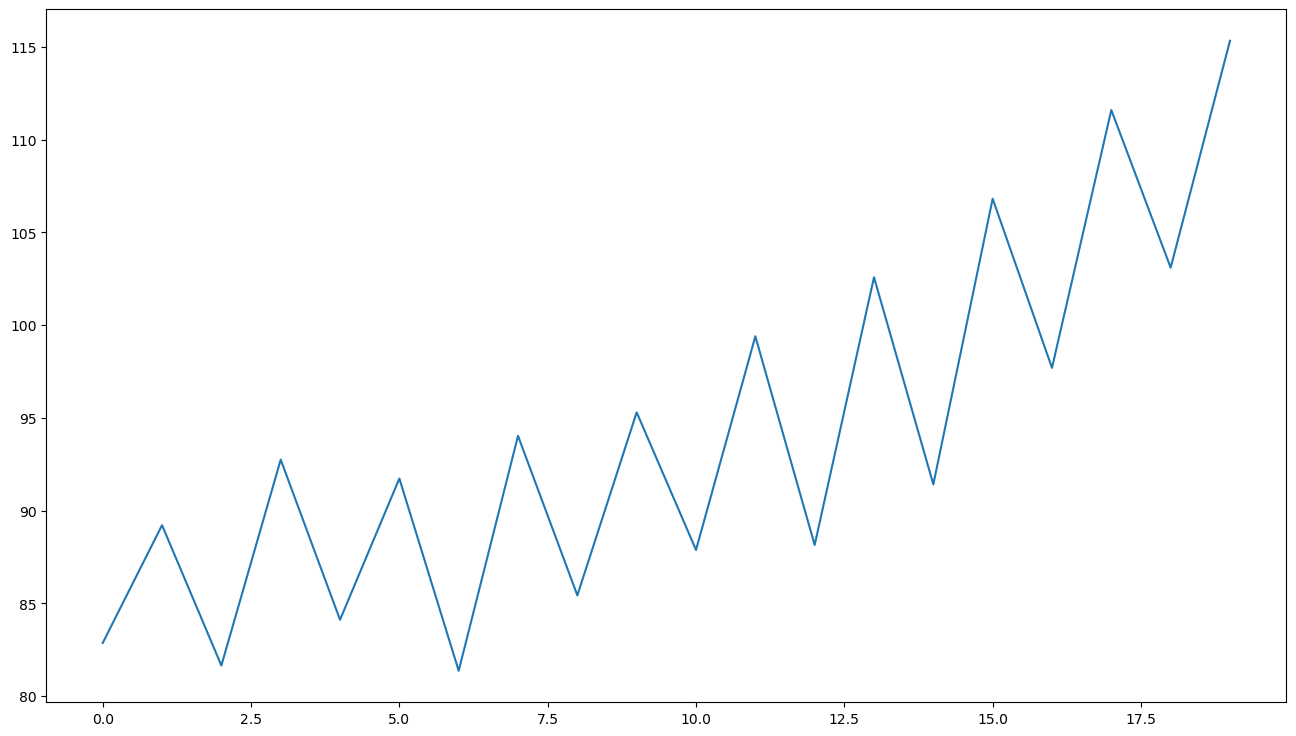

In [29]:
plt.plot(sr1)

In [30]:
sr1

array([ 82.86666667,  89.21666667,  81.65      ,  92.75      ,
        84.11666667,  91.73333333,  81.36666667,  94.03333333,
        85.43333333,  95.3       ,  87.88333333,  99.4       ,
        88.15      , 102.58333333,  91.41666667, 106.81666667,
        97.7       , 111.6       , 103.1       , 115.33333333])

A partir dos resultados do PAA, criar uma sequência para comparação com a série temporal. Sendo assim, para cada elemento de sr1 será criada 6 cópias (120/20). Por isso, os resultados do PAA são apresentados em linhas retas na figura abaixo.

In [31]:
sr2 = np.asarray([[sr1[i] for j in range(int(len(s1) / len(sr1)))] for i in range(len(sr1))])
sr2 = sr2.reshape(-1)

Text(0.5, 1.0, 'Vendas por mês em 10 anos')

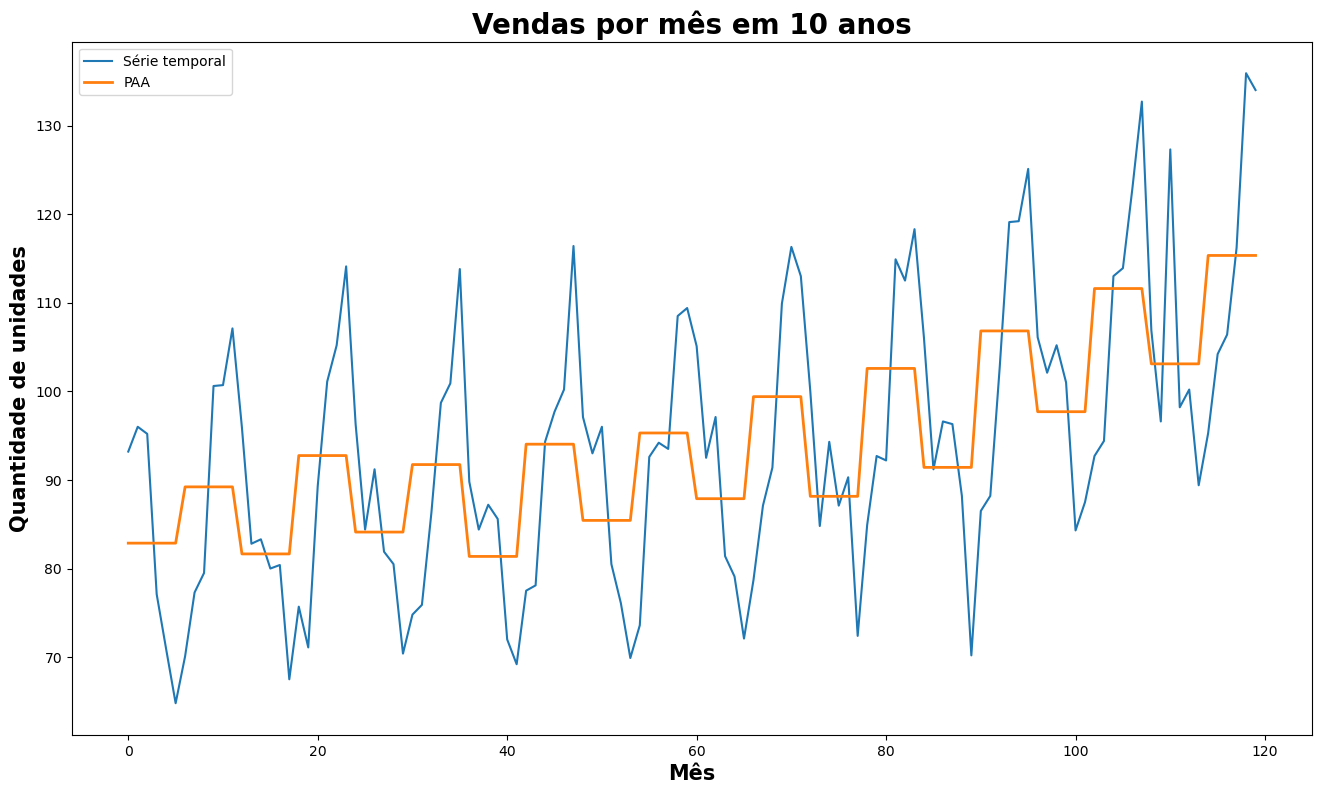

In [32]:
plt.plot(s1)
plt.plot(sr2, linewidth=2)
plt.legend(['Série temporal', 'PAA'])
plt.ylabel('Quantidade de unidades', fontsize = 15, fontweight = 'bold')
plt.xlabel('Mês', fontsize = 15, fontweight = 'bold')
plt.title('Vendas por mês em 10 anos', fontsize = 20, fontweight = 'bold')

## Geração de um espectro de potência e de um espectrograma a partir de uma série temporal

#### Aplicação da transformada discreta de Fourier na série temporal

Note que o algoritmo fft (fast Fourier transform) irá retornar números complexos. Neste caso, para obtermos o espectro de potência, basta fazer |y|^2

Antes da aplicação do algoritmo, carregamos uma série temporal referente à um segmento de EEG com duração de 10 segundos e uma taxa de amostragem de 173.61 Hz

In [33]:
Fs = 173.61 # frequência

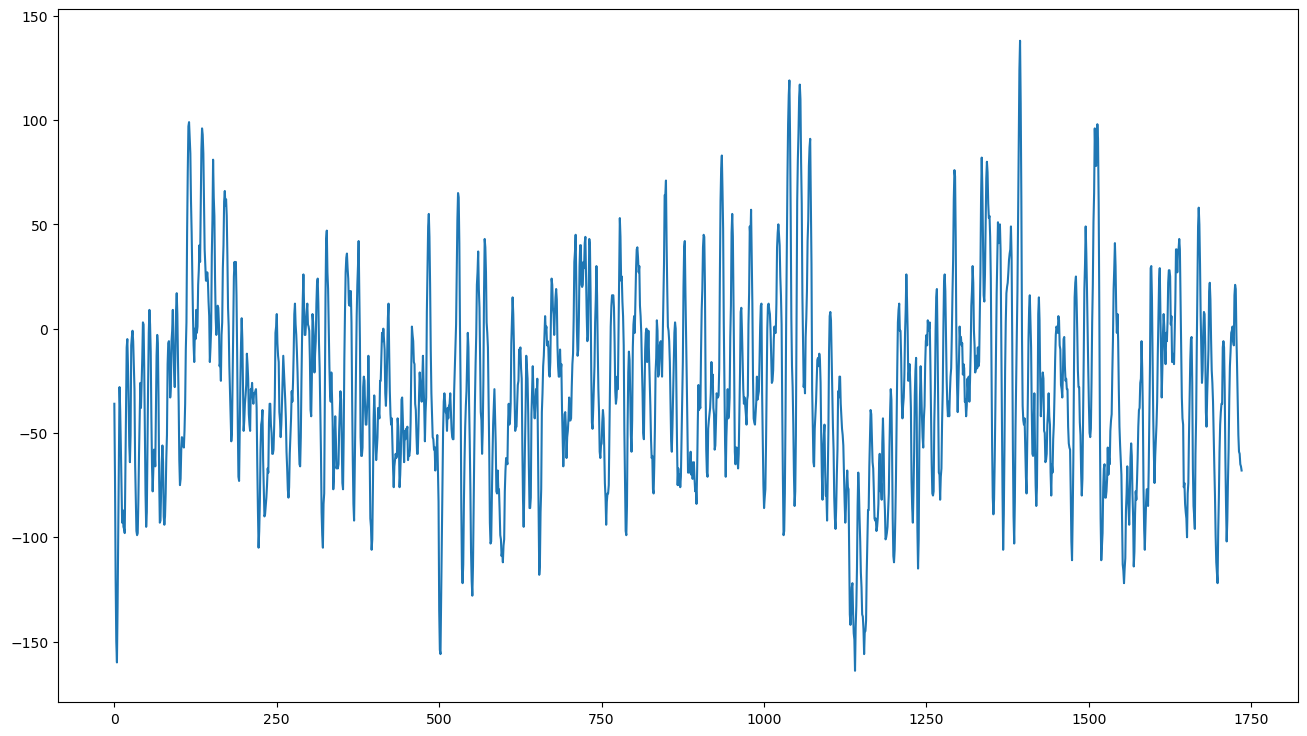

In [34]:
st2 = pd.read_csv("https://raw.githubusercontent.com/jefferson-oliva/databases/refs/heads/main/EEG/EEG_segment.txt")
plt.plot(st2)

In [35]:
st2

,voltage
0,-36
1,-71
2,-120
3,-150
4,-160
...,...
1731,-59
1732,-60
1733,-65
1734,-66


In [36]:
y = fft(np.asarray(st2['voltage']))

Como as duas metades dos componentes são exatamente iguais (para mais informações, procurar por teorema de  teorema de Nyquist), então utilizamos a metade dos componentes.

In [37]:
y = y[0 : int(len(st2) / 2)]

In [38]:
y[0:10]

array([-49601.           -0.j        ,   -179.52092219 +360.90995544j,
         4346.96992224 -418.95133658j, -10582.8844209 -6179.45078864j,
          869.90802222-7563.87313737j,   5421.13356525+4015.7121835j ,
       -14737.86690799+3977.67628766j,  -2083.95202177-3680.42709255j,
        -2927.51893206+8120.99769782j,  -7279.96151106+6682.50882538j])

In [39]:
ep = np.abs(y)**2 # obtenção do espectro de potência da série temporal

Obter a frequência de cada componente do espectro de potência

In [40]:
df = (Fs)/len(ep)
sfreqs = np.arange(0, Fs, df)

Ao plotar, vemos que o espectro possui uma escala (potência) que dificulta a visualização das informações

Text(0, 0.5, 'Potência')

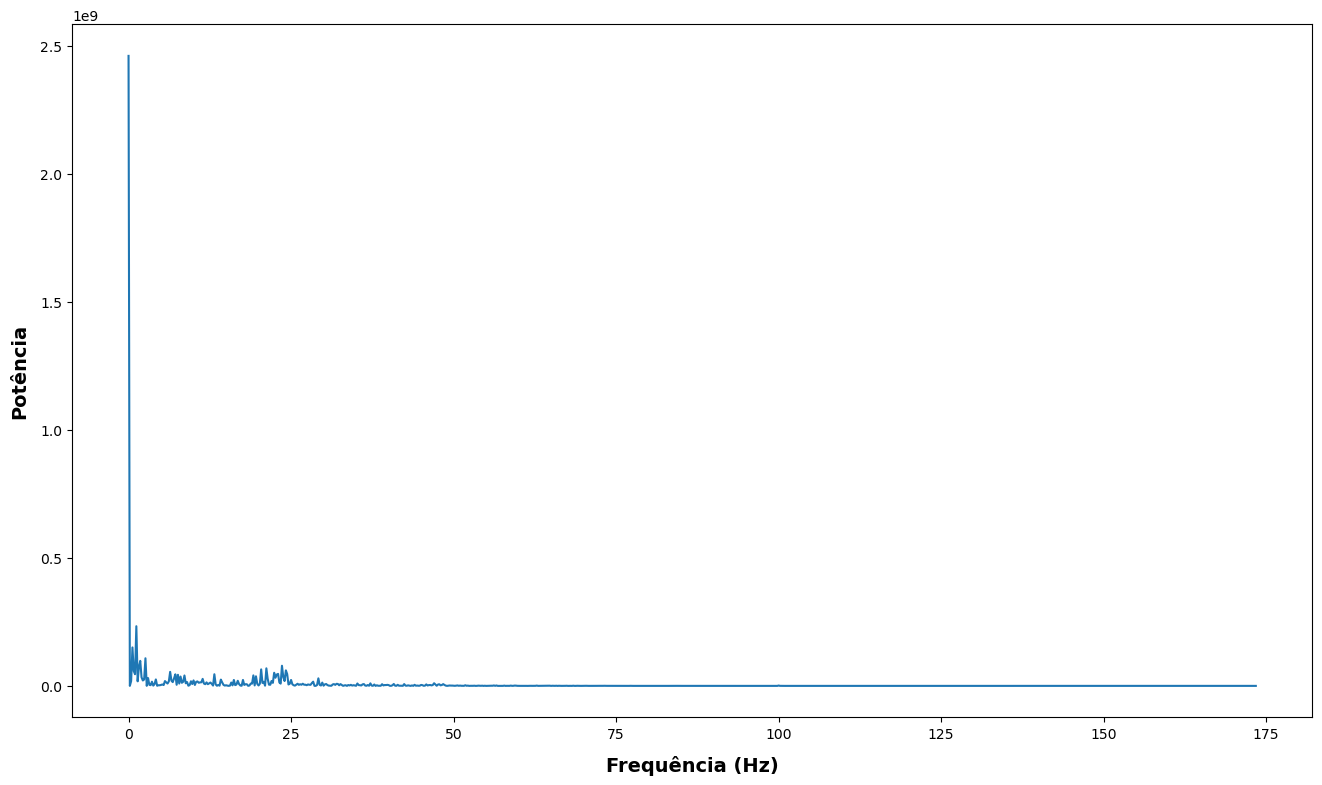

In [41]:
plt.plot(sfreqs,ep)
plt.xlabel("Frequência (Hz)", fontsize = 14, fontweight = 'bold', labelpad = 10)
plt.ylabel("Potência", fontsize = 14, fontweight = 'bold', verticalalignment = 'center', labelpad = 15)

Neste caso, podemos mudar a escala de potência do espectro para decibel (dB)

$Y_{dB} = 10 * log_{10} Y$

In [42]:
dB = 10 * np.log10(y)

/home/utfpr/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/utfpr/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Potência')

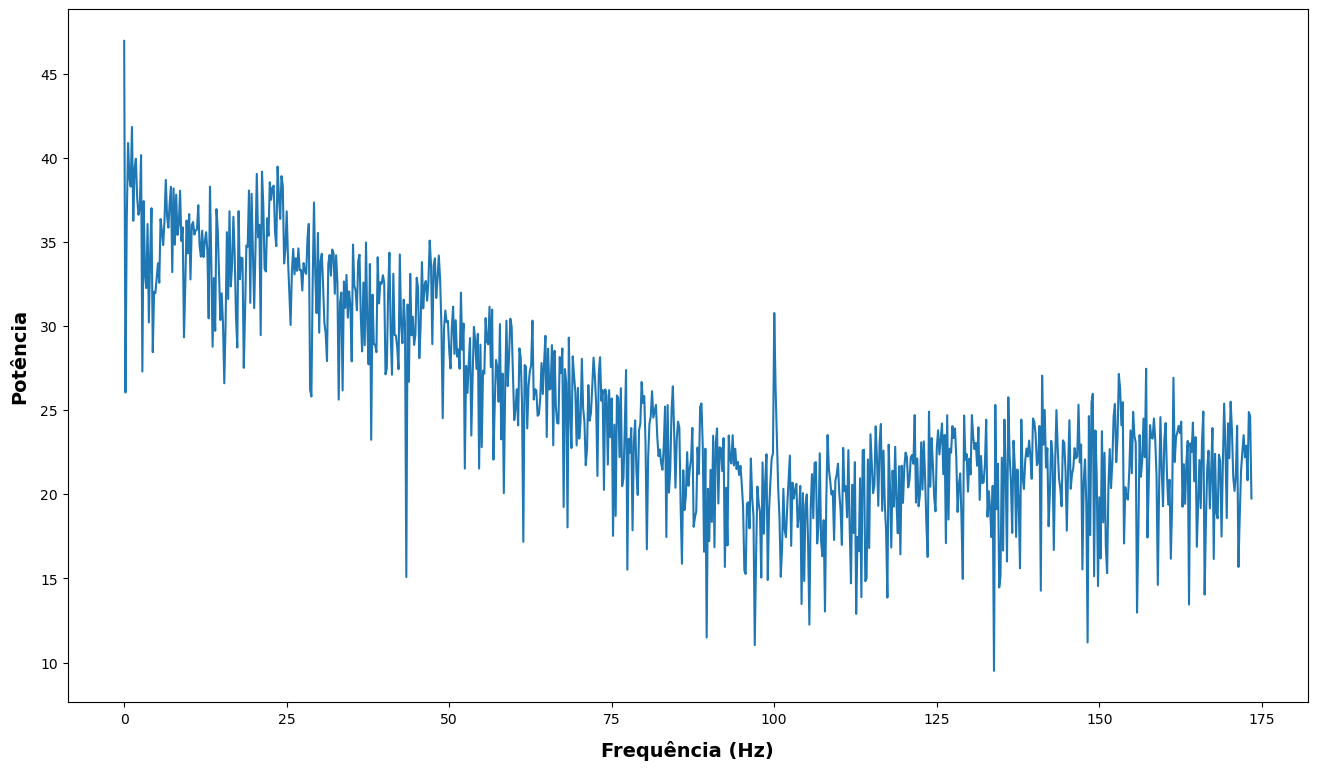

In [43]:
plt.plot(sfreqs, dB)
plt.xlabel("Frequência (Hz)", fontsize = 14, fontweight = 'bold', labelpad = 10)
plt.ylabel("Potência", fontsize = 14, fontweight = 'bold', verticalalignment = 'center', labelpad = 15)

#### Aplicação da transformada discreta de Fourier de curto termo na série temporal

Nesta aplicação, será reaproveitada a série temporal utilizada na aplicação do algoritmo fft

In [44]:
sfreqs, time, y2D = stft(np.asarray(st2['voltage']), Fs)

Gerar espectrograma

In [45]:
eg = np.abs(y2D)**2

Text(0.5, 0, 'Tempo (s)')

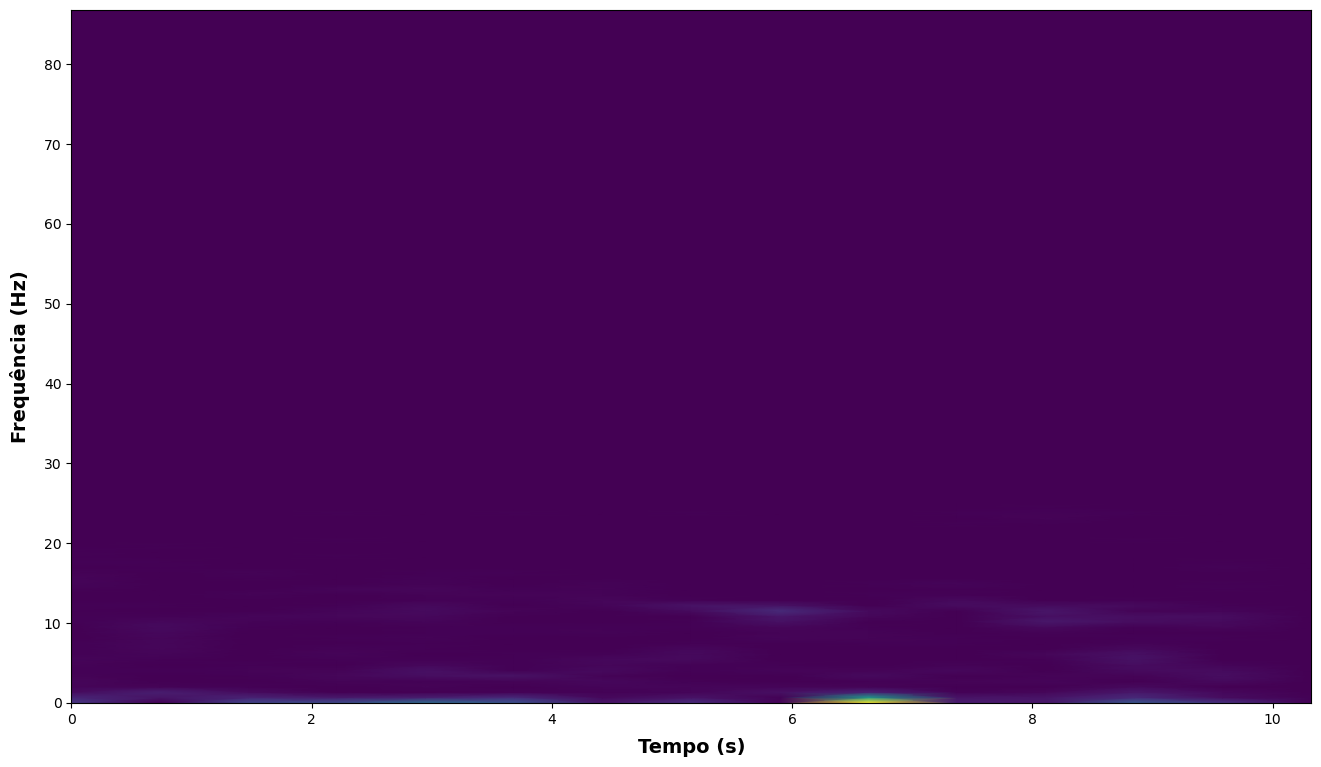

In [46]:
plt.pcolormesh(time, sfreqs, eg, shading = 'gouraud')
plt.ylabel("Frequência (Hz)", fontsize = 14, fontweight = 'bold', labelpad = 10)
plt.xlabel("Tempo (s)", fontsize = 14, fontweight = 'bold', verticalalignment = 'center', labelpad = 15)

In [47]:
dB2D = 10 * np.log10(eg)

Text(0.5, 0, 'Tempo (s)')

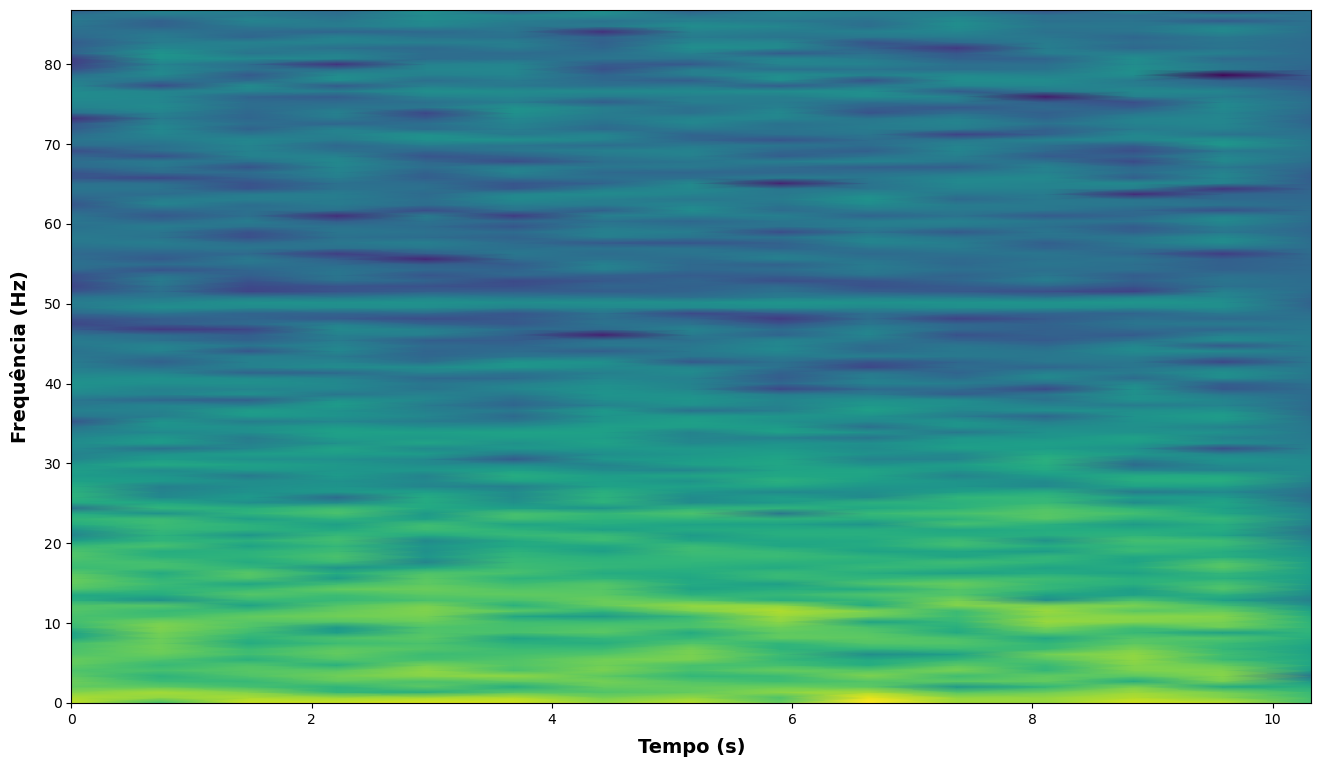

In [48]:
plt.pcolormesh(time, sfreqs, dB2D, shading = 'gouraud')
plt.ylabel("Frequência (Hz)", fontsize = 14, fontweight = 'bold', labelpad = 10)
plt.xlabel("Tempo (s)", fontsize = 14, fontweight = 'bold', verticalalignment = 'center', labelpad = 15)

## Predição de valores em séries temporais

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


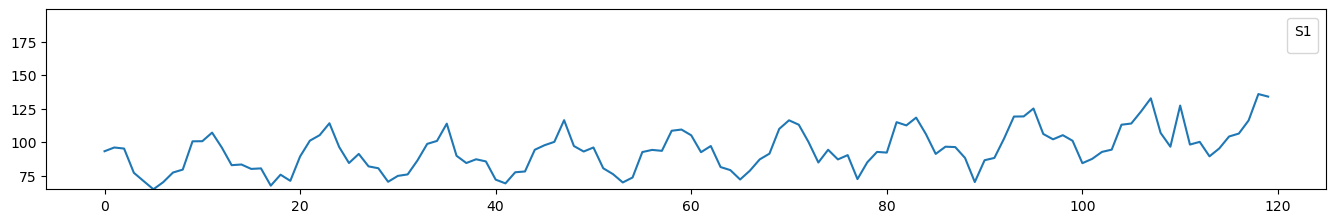

In [49]:
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.7, 0.8, 0.2], ylim = (y_min, y_max))
ax1.plot(s1)
ax1.legend(title = "S1", loc = 1, fontsize = 12)

In [50]:
tam = int(0.9 * len(s1)) # o segmento terá 90% do tamanho da série
treino = s1[0 : tam] # segmento da série temporal em que será realizada a predição
teste = s1[tam : ] # segmento da série temporal em que serão realizadas comparações com os resultados da predição

### Modelos autorregressivo, médias móveis, ARMA e ARIMA

In [51]:
mARMA = ARIMA(treino, order = (45, 0, 60)).fit() # Modelo ARMA

/home/utfpr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/utfpr/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


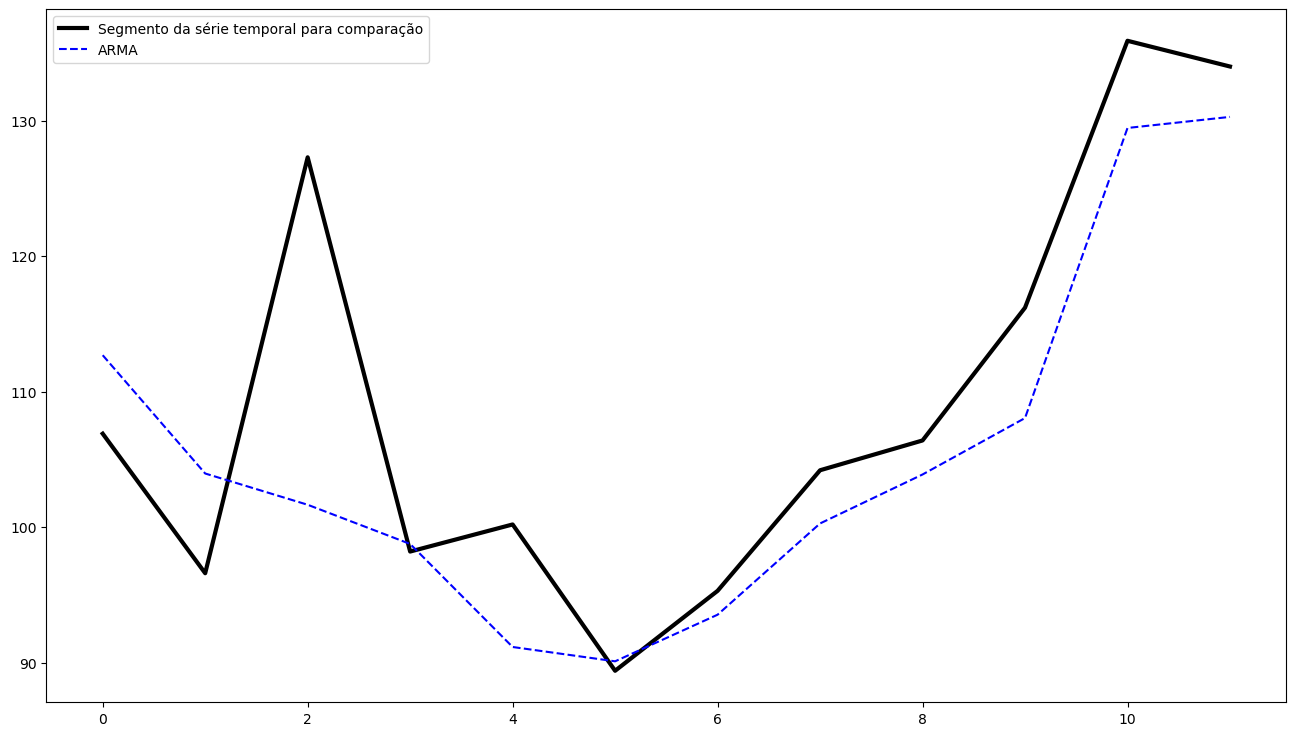

In [52]:
pred_ARMA = mARMA.predict(start = len(treino), end = len(treino) + len(teste) - 1, dynamic = False)

plt.plot(teste, color='black', linewidth=3)
plt.plot(pred_ARMA, color='blue', linestyle='dashed')
plt.legend(['Segmento da série temporal para comparação', 'ARMA'])

#### Modelo AR utilizando ARIMA

In [53]:
mAR = ARIMA(treino, order = (45, 0, 0)).fit() # Modelo AR

/home/utfpr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/utfpr/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


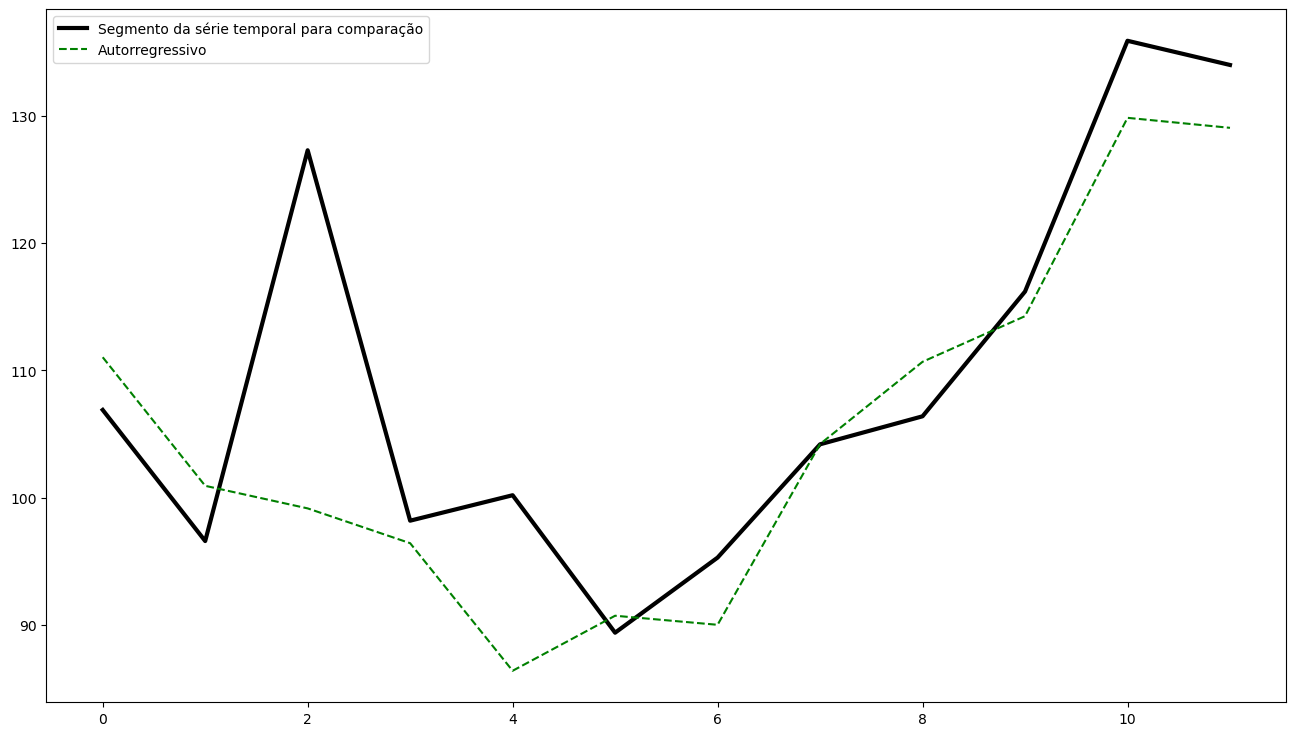

In [54]:
pred_AR = mAR.predict(start = len(treino), end = len(treino) + len(teste) - 1, dynamic = False)

plt.plot(teste, color='black', linewidth = 3)
plt.plot(pred_AR, color='green', linestyle = 'dashed')
plt.legend(['Segmento da série temporal para comparação', 'Autorregressivo'])

#### Modelo MM utilizando ARIMA

In [55]:
mMM = ARIMA(treino, order = (0, 0, 60)).fit()

/home/utfpr/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


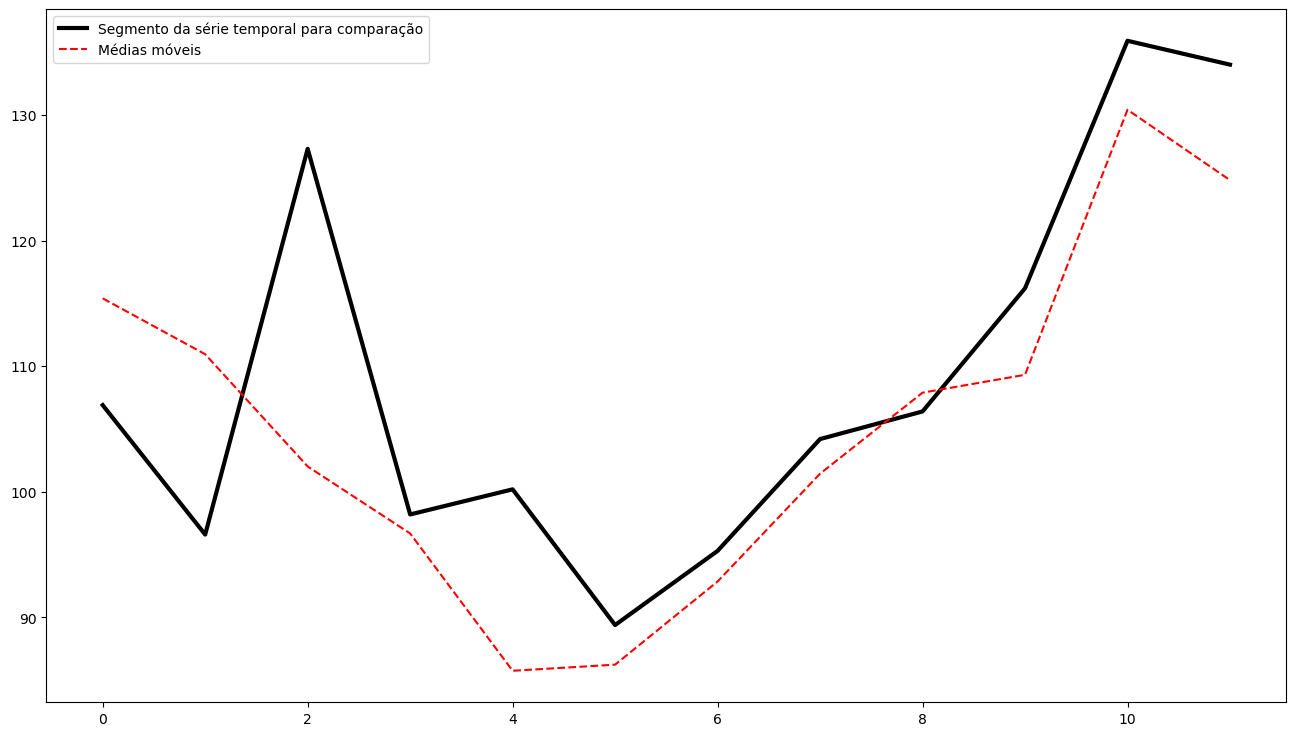

In [56]:
pred_MM = mMM.predict(start = len(treino), end = len(treino) + len(teste) - 1, dynamic = False)

plt.plot(teste, color='black', linewidth=3)
plt.plot(pred_MM, color='red', linestyle='dashed')
plt.legend(['Segmento da série temporal para comparação', 'Médias móveis'])

#### Modelo ARIMA

In [57]:
mARIMA = ARIMA(treino, order = (15, 1, 15)).fit()

/home/utfpr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/utfpr/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


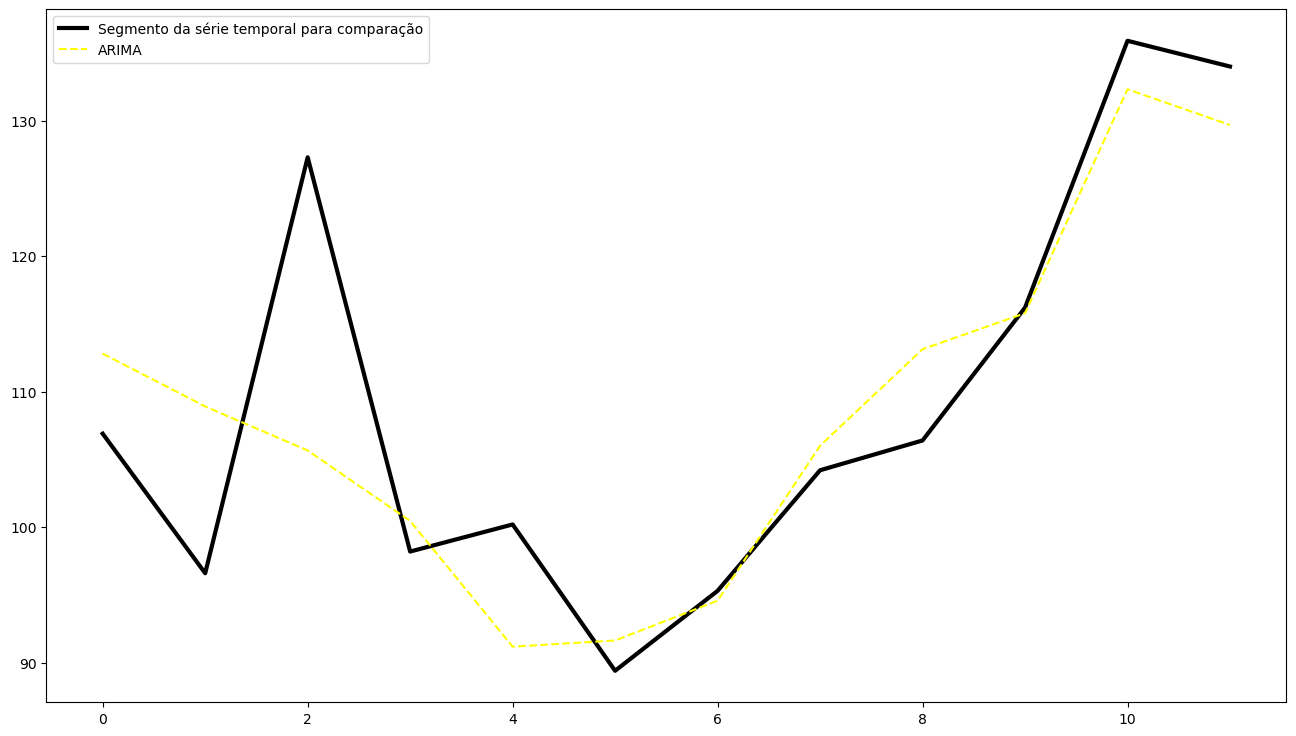

In [58]:
pred_ARIMA = mARIMA.predict(start = len(treino), end = len(treino) + len(teste) - 1, dynamic = False)

plt.plot(teste, color='black', linewidth=3)
plt.plot(pred_ARIMA, color='yellow', linestyle='dashed')
plt.legend(['Segmento da série temporal para comparação', 'ARIMA'])

### Comparação entre os modelos

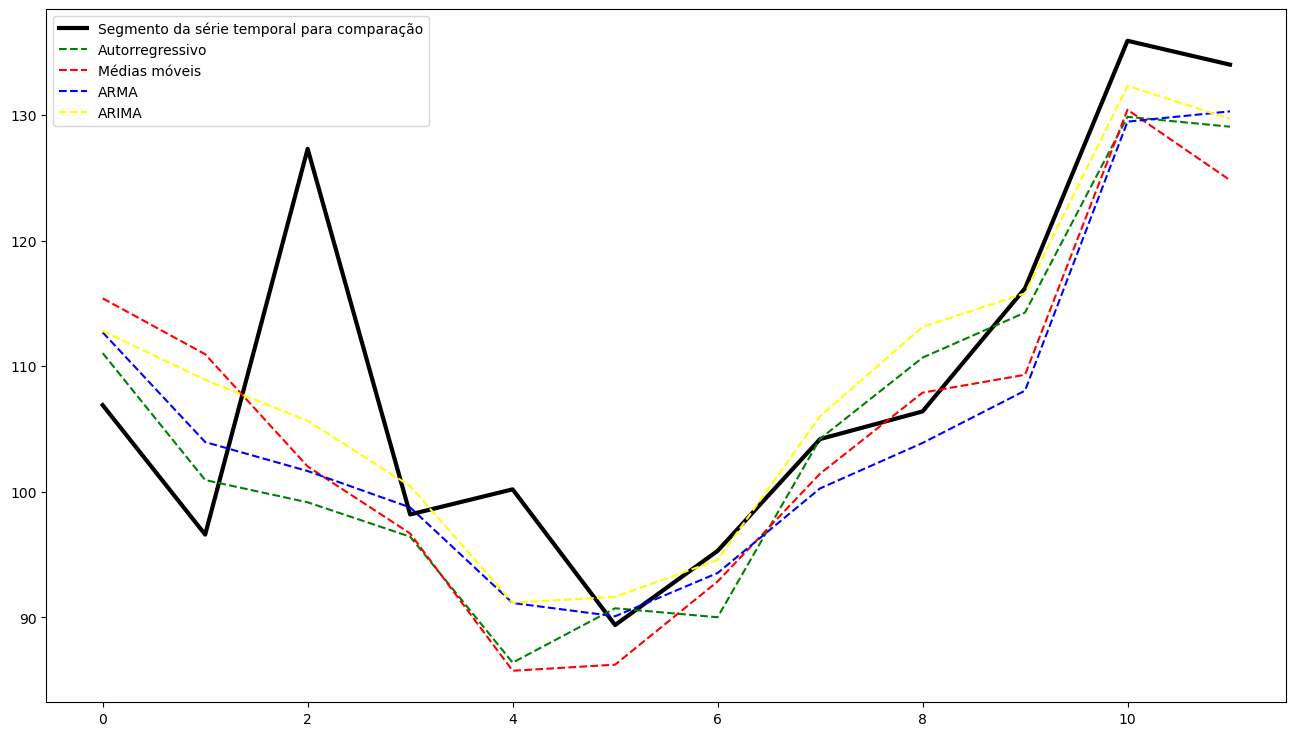

In [59]:
plt.plot(teste, color='black', linewidth=3)
plt.plot(pred_AR, color='green', linestyle='dashed')
plt.plot(pred_MM, color='red', linestyle='dashed')
plt.plot(pred_ARMA, color='blue', linestyle='dashed')
plt.plot(pred_ARIMA, color='yellow', linestyle='dashed')

plt.legend(['Segmento da série temporal para comparação', 'Autorregressivo', 'Médias móveis', 'ARMA', 'ARIMA'])

## Avaliação dos modelos

In [60]:
print('MSE para AR: %.3f' % mean_squared_error(teste, pred_AR))
print('MSE para MM: %.3f' % mean_squared_error(teste, pred_MM))
print('MSE para ARMA: %.3f' % mean_squared_error(teste, pred_ARMA))
print('MSE para ARIMA: %.3f' % mean_squared_error(teste, pred_ARIMA))

MSE para AR: 94.467
MSE para MM: 109.652
MSE para ARMA: 81.209
MSE para ARIMA: 68.917


In [61]:
print('RMSE para AR: %.3f' % np.sqrt(mean_squared_error(teste, pred_AR)))
print('RMSE para MM: %.3f' % np.sqrt(mean_squared_error(teste, pred_MM)))
print('RMSE para ARMA: %.3f' % np.sqrt(mean_squared_error(teste, pred_ARMA)))
print('RMSE para ARIMA: %.3f' % np.sqrt(mean_squared_error(teste, pred_ARIMA)))

RMSE para AR: 9.719
RMSE para MM: 10.471
RMSE para ARMA: 9.012
RMSE para ARIMA: 8.302


In [62]:
print('MAE para AR: %.3f' % mean_absolute_error(teste, pred_AR))
print('MAE para MM: %.3f' % mean_absolute_error(teste, pred_MM))
print('MAE para ARMA: %.3f' % mean_absolute_error(teste, pred_ARMA))
print('MAE para ARIMA: %.3f' % mean_absolute_error(teste, pred_ARIMA))

MAE para AR: 6.334
MAE para MM: 7.957
MAE para ARMA: 6.300
MAE para ARIMA: 5.913


## Validação cruzada no modelo ARIMA

In [63]:
stA = np.asarray(st['Monthly beer production'])

In [64]:
tss = TimeSeriesSplit(n_splits = 10)
mse = []
rmse = []
mae = []

/home/utfpr/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/utfpr/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/utfpr/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/utfpr/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/utfpr/anaconda3/lib/python3.11/site-packages/statsmod

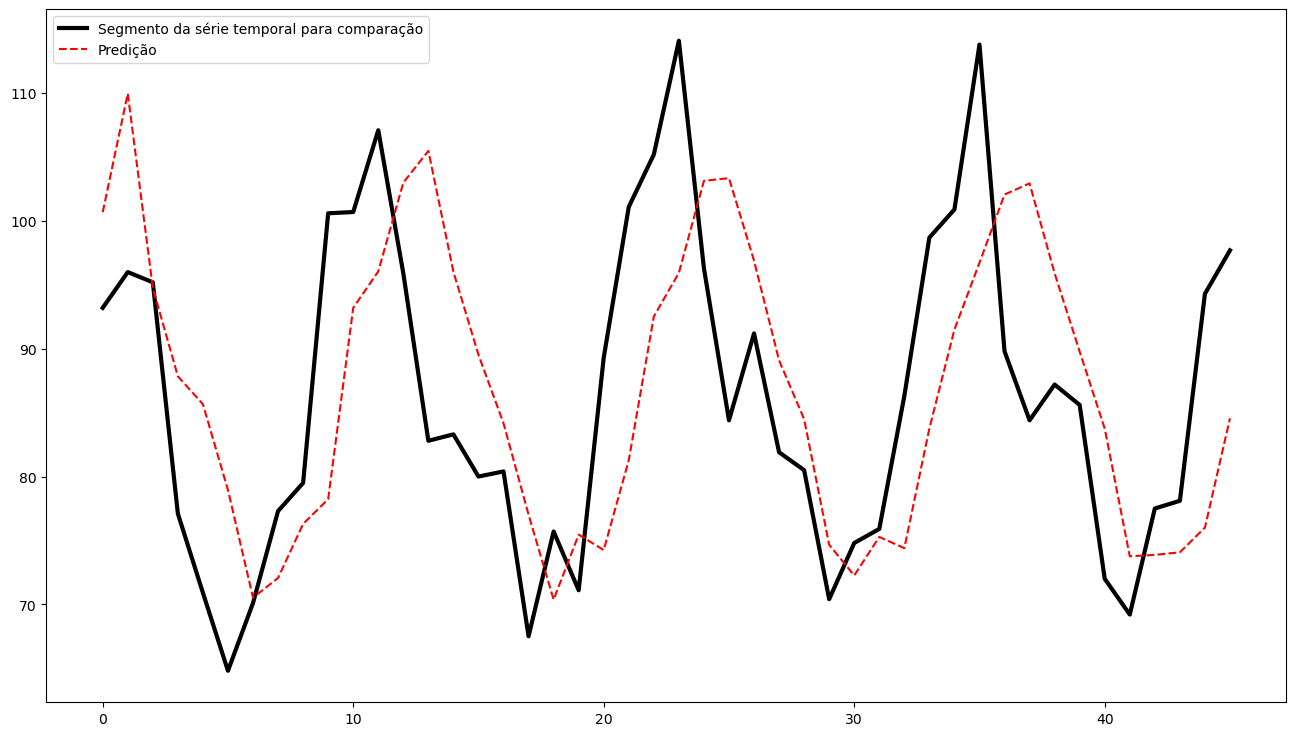

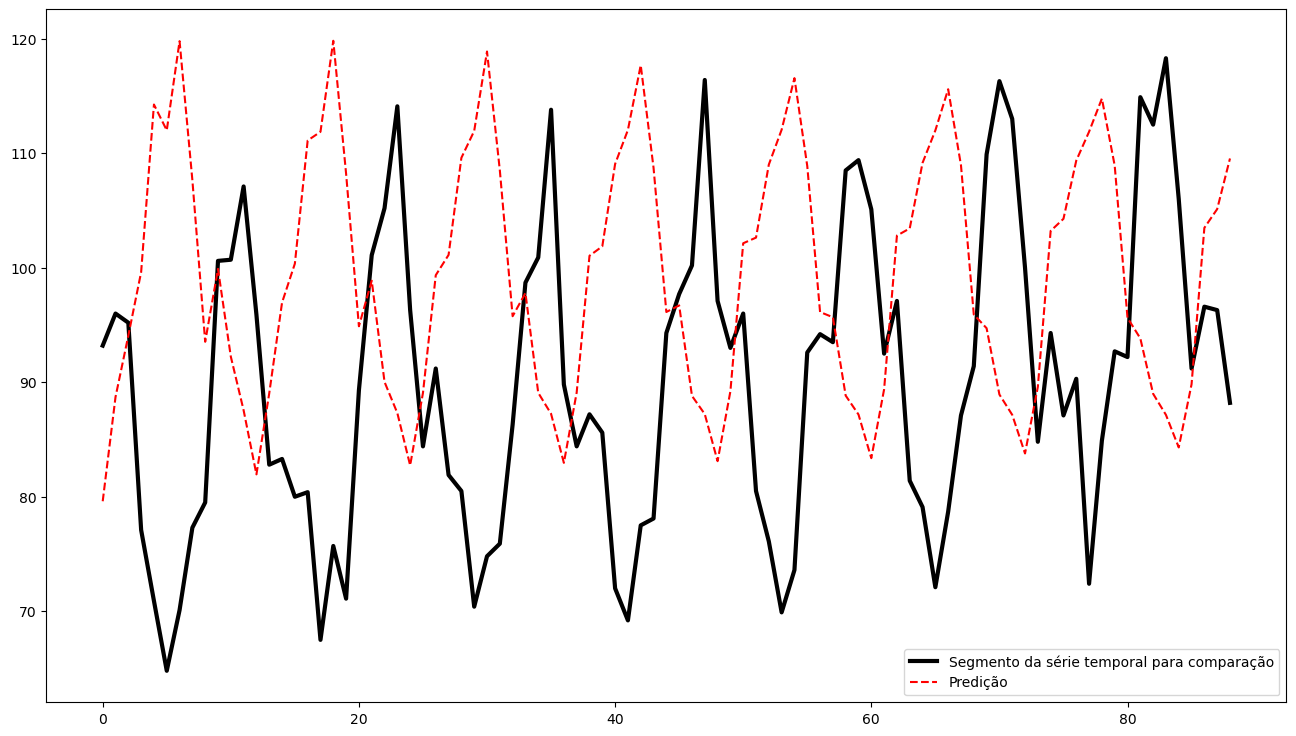

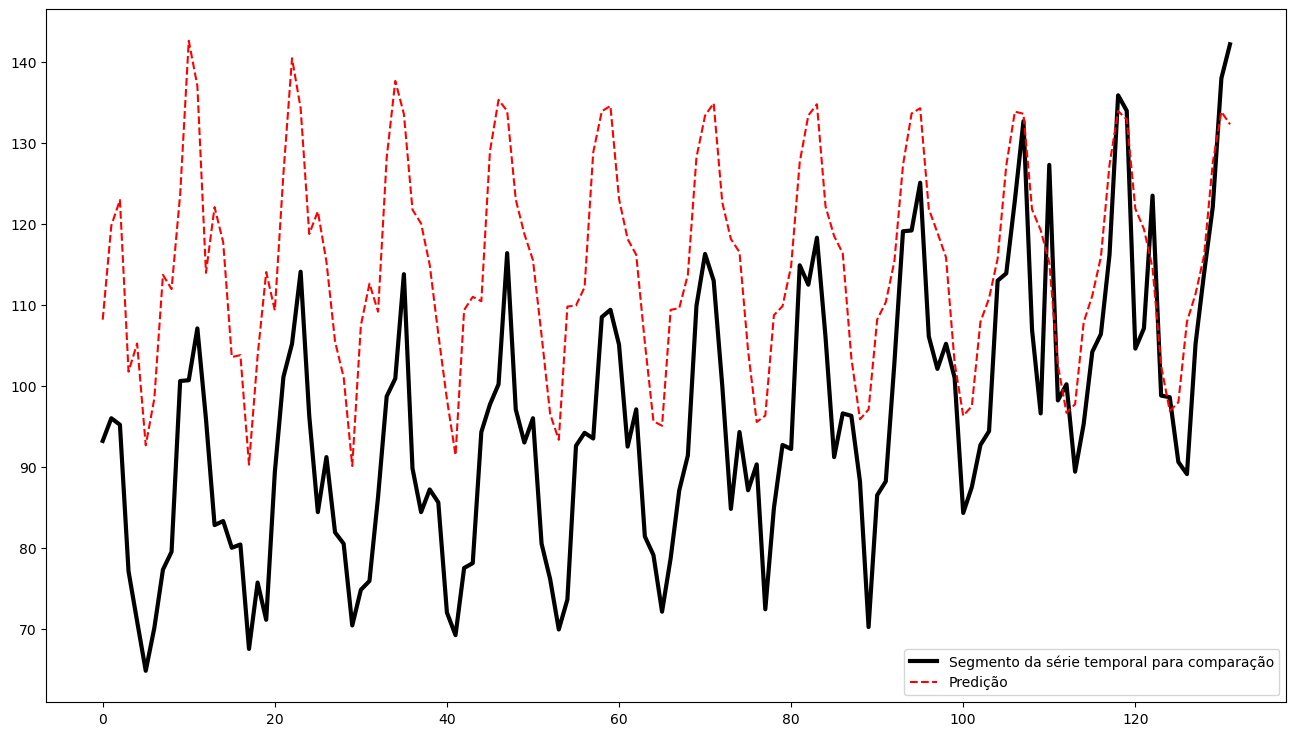

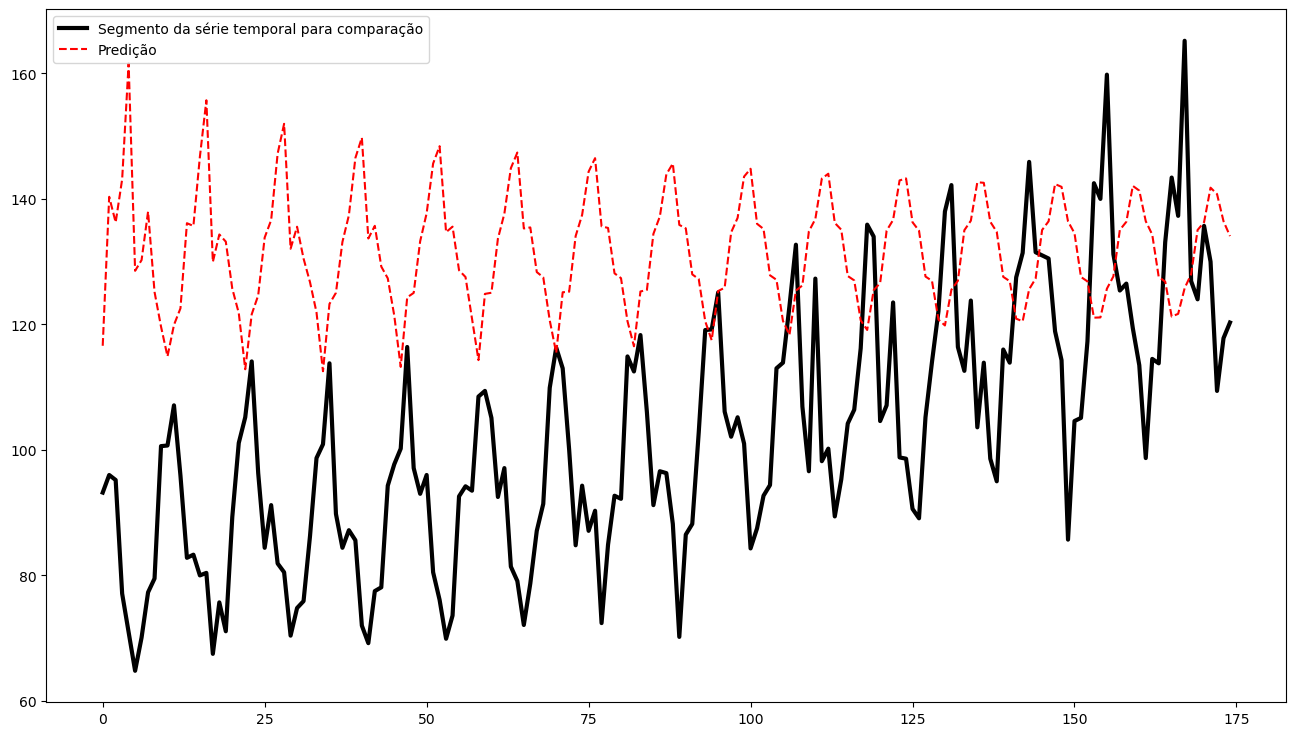

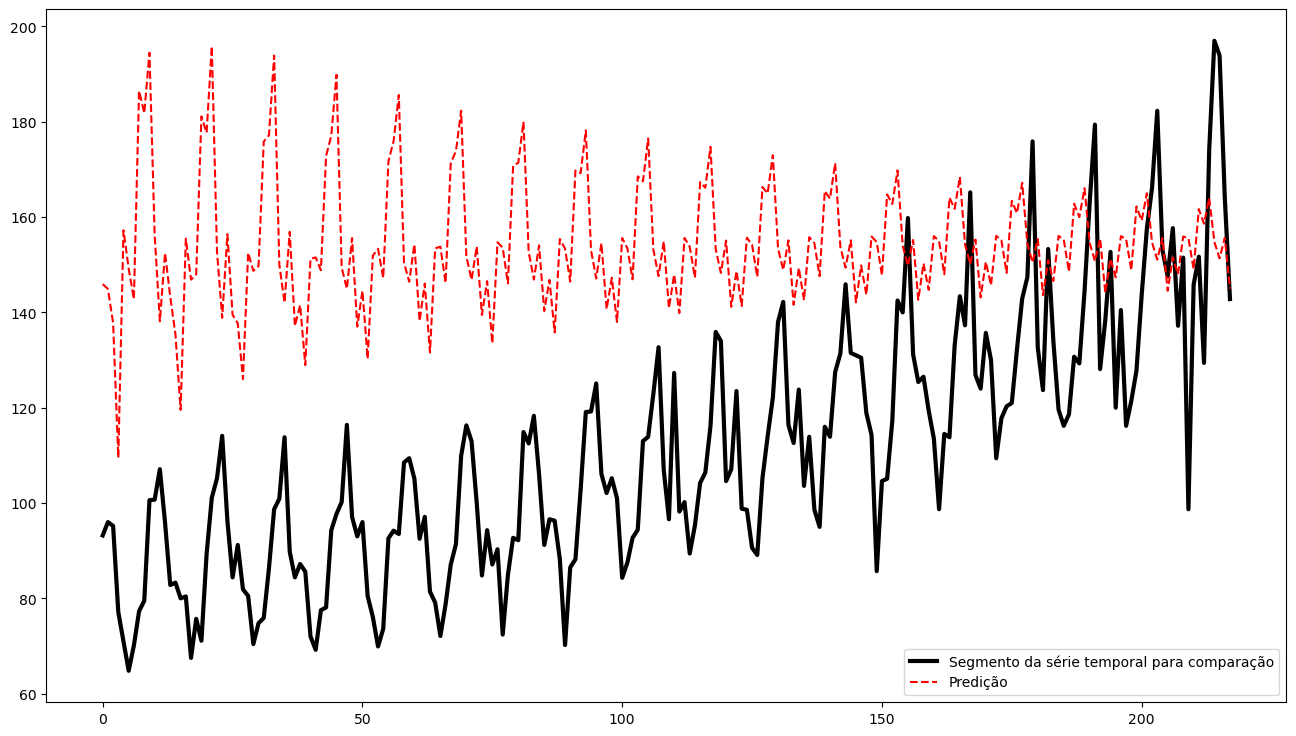

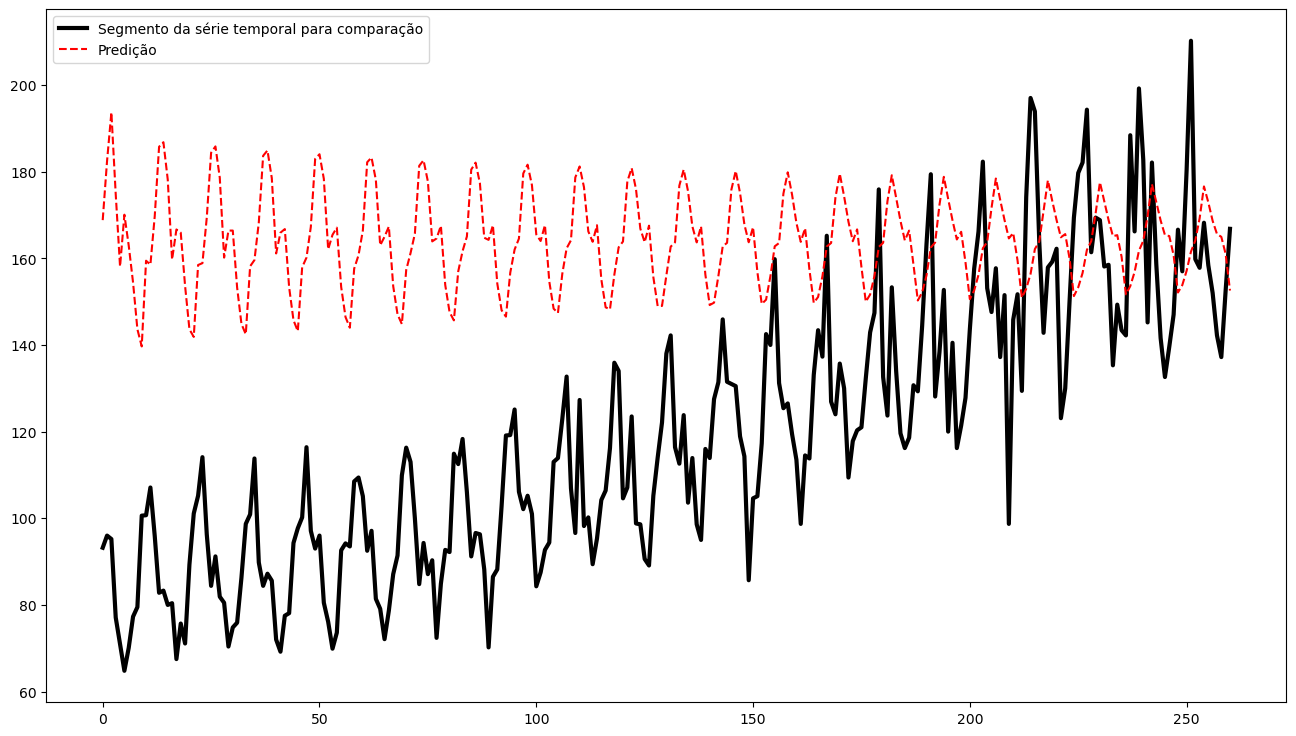

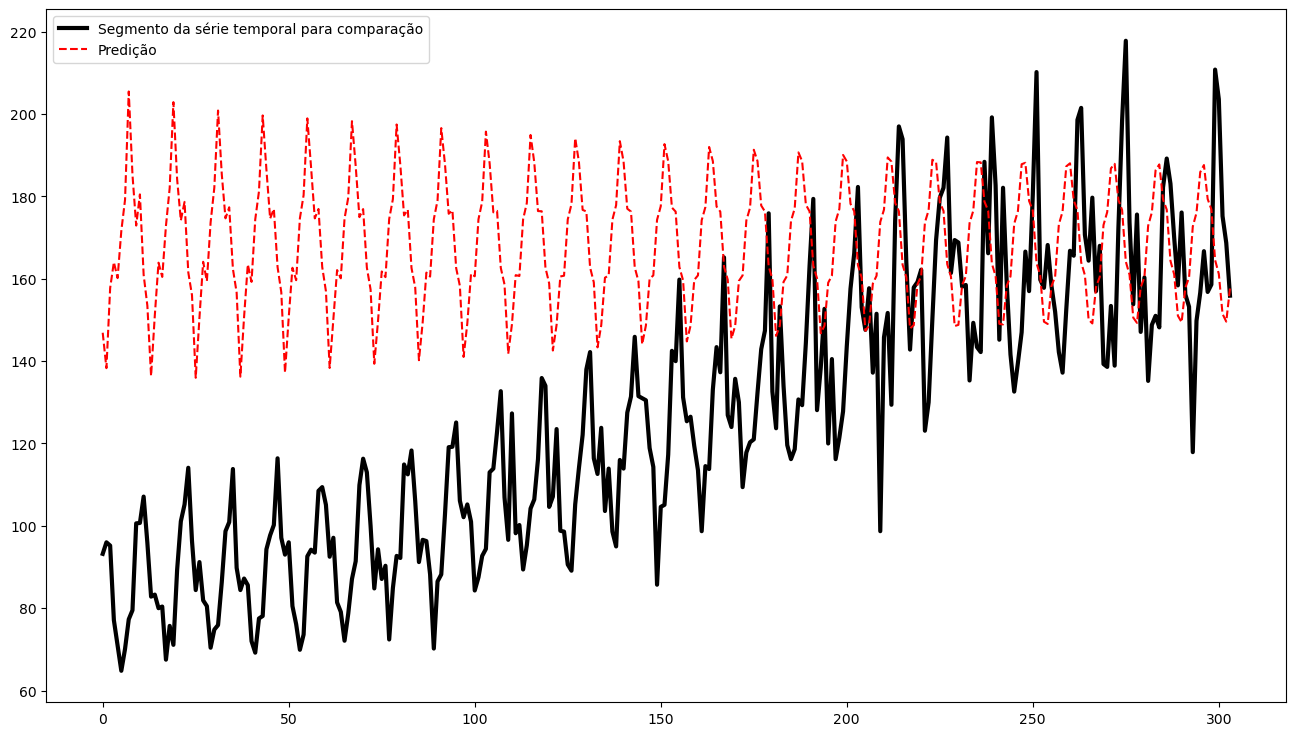

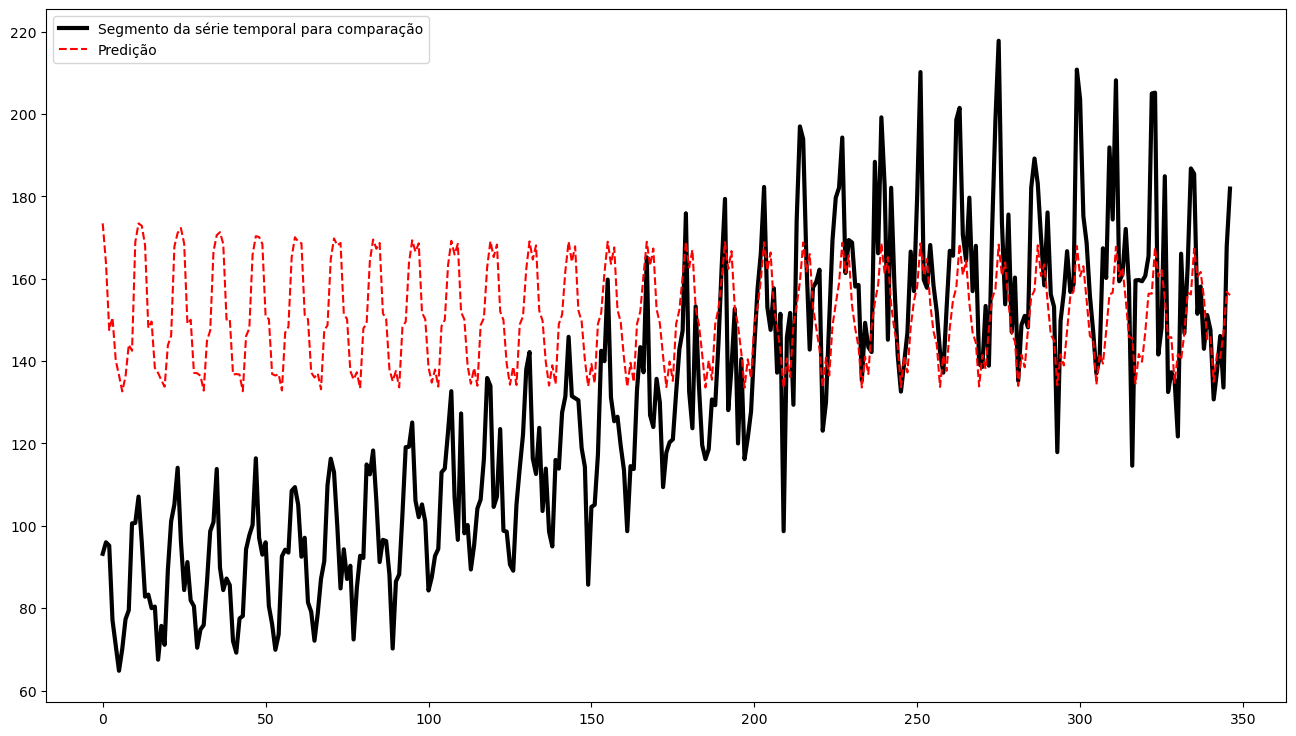

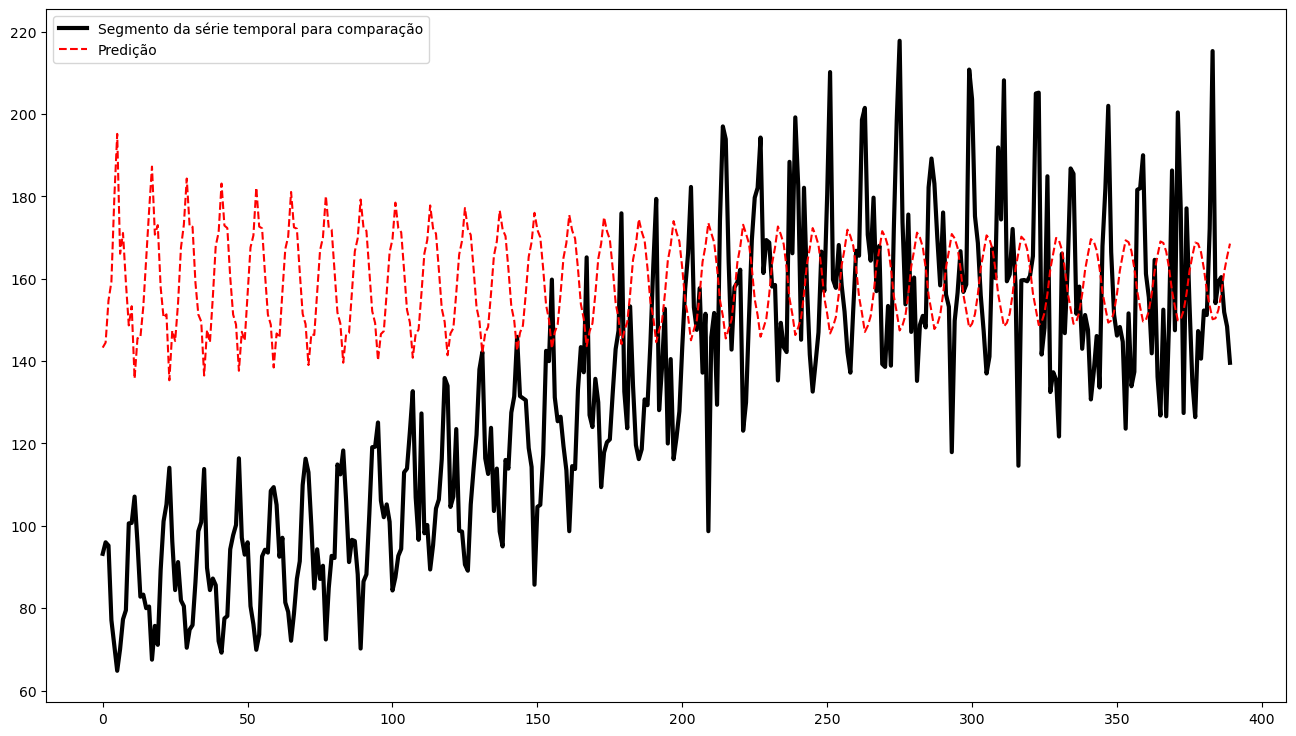

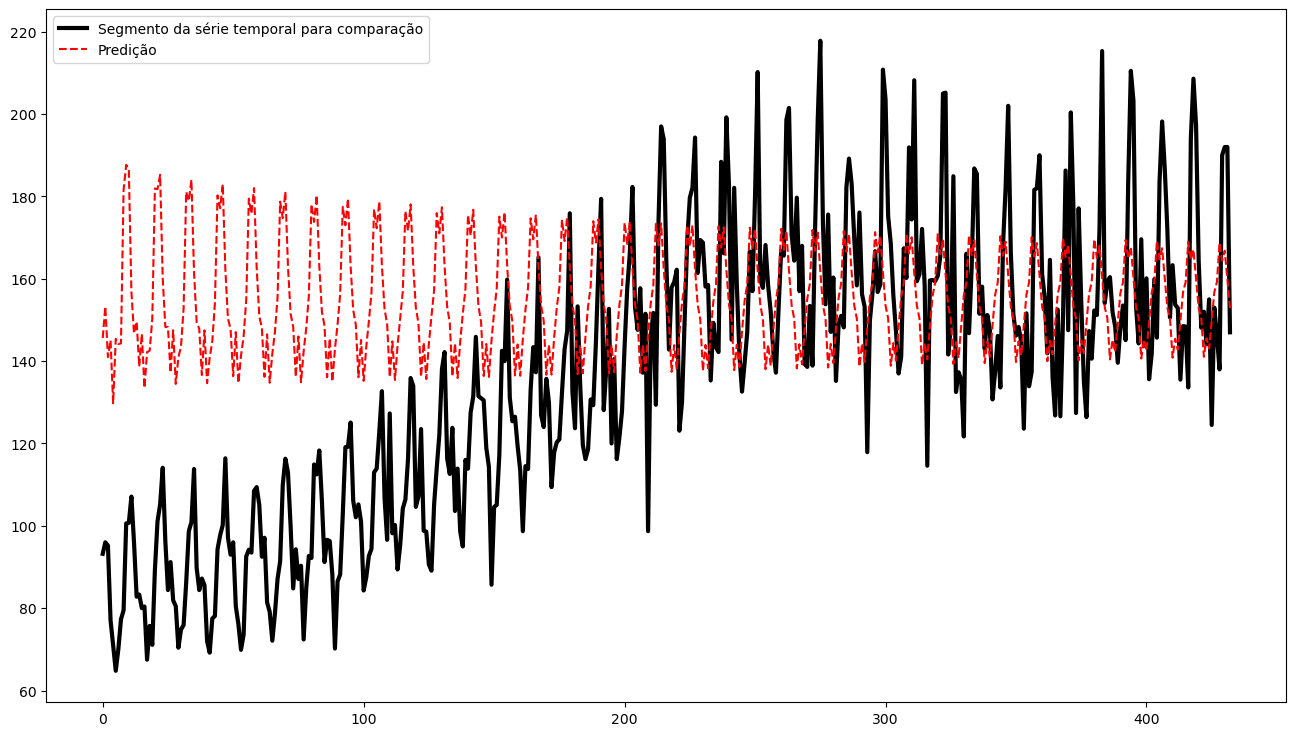

In [65]:
for i_treino, i_teste in tss.split(stA):
    treino = stA[i_treino]
    teste = stA[i_treino]
    
    modelo = ARIMA(treino, order = (10, 1, 10)).fit()
    pred = modelo.predict(start = len(treino), end = len(treino) + len(teste) - 1, dynamic = False)
    
    plt.figure()
    plt.plot(teste, color='black', linewidth=3)
    plt.plot(pred, color='red', linestyle='dashed')
    plt.legend(['Segmento da série temporal para comparação', 'Predição'])
    
    mae.append(mean_absolute_error(teste, pred))
    rmse.append(np.sqrt(mae[-1]))
    mse.append(mean_squared_error(teste, pred))

In [66]:
print('MSE: %.3f' % np.mean(mse))
print('RMSE: %.3f' % np.mean(rmse))
print('MAE: %.3f' % np.mean(mae))

MSE: 1732.182
RMSE: 5.602
MAE: 32.804
